<a href="https://colab.research.google.com/github/astikasinha/Grammar-Scoring-System-SHL-Assessment/blob/main/work_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**BRIEF REPORT**
# Spoken English Grammar Scoring

## Objective
To develop a system that predicts a grammar proficiency score (1 to 5) from spoken English audio recordings. This is achieved by combining audio-based and text-based (transcription) features for training a machine learning model.

---

##  Approach Overview

1. Audio files are transcribed using the Whisper ASR model.
2. Transcriptions are analyzed using LanguageTool to extract grammar-related features.
3. Audio features (like pitch, energy, and MFCCs) are extracted using librosa.
4.  Combined features are used to train an XGBoost regression model to predict grammar scores.
5. Model is evaluated using standard regression metrics and a custom accuracy.

---

## Pipeline Architecture

### 1. Preprocessing
- Transcription via Whisper (`base` model, fp16 disabled for Colab CPU compatibility).
- Grammar error detection using `language_tool_python`.
- Audio feature extraction via librosa (duration, MFCC mean/std, pitch, etc.).

### 2. Feature Engineering
## Feature Description

This project focuses on predicting grammar proficiency scores from spoken audio responses. The features used in the model are derived from both the raw audio signal and the transcribed text using a combination of speech recognition, natural language processing, and audio signal processing techniques.

---

### 1. Audio Features (Extracted using librosa)

These features capture the underlying acoustic and temporal properties of the audio recording. They help understand pronunciation clarity, articulation, rhythm, and energy which are indirectly linked to fluency and delivery.

####  Basic Audio Properties:
- `duration`: Total duration of the audio (in seconds), capturing the overall length of spoken response.
- `zero_crossing_rate_mean` / `zero_crossing_rate_std`: Measures how frequently the signal changes sign, useful for detecting voice activity and sharp transitions.
- `energy_mean` / `energy_std`: Root Mean Square (RMS) energy; indicates loudness and consistency in speech delivery.
- `spectral_centroid_mean` / `spectral_centroid_std`: Indicates where the "center of mass" of the spectrum is located; related to perceived brightness of sound.
- `spectral_rolloff_mean` / `spectral_rolloff_std`: The frequency below which a certain percentage of the total spectral energy lies.
- `spectral_bandwidth_mean` / `spectral_bandwidth_std`: Width of the frequency band; reflects voice dynamics.

####  Pitch Features:
- `pitch_mean` / `pitch_std`: Average and variability in pitch (fundamental frequency); can capture prosody and intonation patterns.
- `pitch_max` / `pitch_min`: Range of pitch values; higher variation may indicate expressive or erratic speech.

####  MFCCs (Mel-Frequency Cepstral Coefficients):
- MFCCs mimic human auditory perception and are widely used in speech processing.
- For each of the first 13 MFCC coefficients:
  - `mfcc_i_mean` and `mfcc_i_std` (i = 1 to 13): Mean and standard deviation across the audio timeline.

Total Audio Features: 11 (basic) + 4 (pitch) + 26 (MFCCs) = 41 features

---

### 2. Grammar Features (From transcribed text using Whisper + LanguageTool)

After converting the audio into text using OpenAI's Whisper model, grammar analysis is performed using the LanguageTool API.

- `num_words`: Total number of words in the transcribed response.
- `num_sentences`: Number of sentence boundaries detected.
- `avg_sentence_length`: Mean number of words per sentence; indicates sentence complexity.
- `num_grammar_errors`: Total grammar/spelling mistakes identified.
- `error_rate`: Ratio of grammar errors to total words; captures correctness and fluency.

These features help evaluate the correctness, coherence, and complexity of the speaker's grammar.

Total Grammar Features: 5

---

### Final Feature Count
- Audio-Based Features: 41  
- Text-Based Grammar Features: 5  
- Total Combined Features: 46

These features were standardized before training to ensure balanced learning across scales.


### 3. Heuristic Grammar Scoring (for testing set)
- A rule-based function maps grammar error stats to a discrete score (1.0 to 5.0).


###  4. Modeling Approach

The modeling pipeline is designed to learn the relationship between engineered audio/text features and the target grammar proficiency score (ranging from 1.0 to 5.0). Below are the key components of the modeling architecture:

---

####  Feature Normalization

- Standardized all feature values using Scikit-learn's StandardScaler.
- This ensures each feature contributes equally to the model training, especially important for algorithms like XGBoost.

---

#### Model Used: XGBoost Regressor

XGBoost is a powerful, tree-based ensemble learning algorithm known for its high performance and robustness to overfitting. It was chosen for its ability to handle nonlinear feature interactions and small-to-medium sized datasets effectively.

- Model Parameters:
  - n_estimators: 400 — number of boosting rounds (trees).
  - max_depth: 7 — maximum depth of a tree to control complexity.
  - learning_rate: 0.03 — step size shrinkage used in update to prevent overfitting.
  - subsample: 0.8 — fraction of training instances used in each boosting round.
  - colsample_bytree: 0.8 — fraction of features used for constructing each tree.
  - random_state: 42 — ensures reproducibility.

---

####  Model Training and Validation

- Data Split: 80% training / 20% validation
- The model was trained using the preprocessed features and evaluated using regression metrics (RMSE, R², and custom accuracy).



---

## Evaluation Results (Validation Set)

- RMSE: ≈ 0.8413
- R² Score: ≈ 0.4808
- Custom Accuracy (within ±0.5 tolerance): 0.4607

###  Visualizations
- Feature importance (top 20 features by gain).
- Actual vs Predicted scatter plot.
- Residual histogram (errors centered around 0).
- Predicted vs Actual curves for first 100 samples.

---

## Submission
- Test audios are processed with the heuristic scoring function.
- Predictions saved in `submission.csv` in the required format (`filename`, `label`).

---





**Required Python Libraries**

<span style="font-size:13px">

Whisper: OpenAI's speech-to-text model for audio transcription  

LanguageTool: Grammar checking tool to extract grammar features from text

Librosa: Audio processing library to extract features like MFCC, pitch, etc.  

scikit-learn: Machine learning tools for preprocessing, modeling, and evaluation  

pandas: Data manipulation and handling of CSV files  

numpy: Numerical operations and array manipulations  

xgboost: Gradient boosting model for regression or classification
</span>


In [1]:
!pip install openai-whisper language-tool-python librosa scikit-learn pandas numpy xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 34.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s e

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Imported Python Libraries**

<span style="font-size:12px">

- `os`: Interface with the operating system (e.g., path manipulations).
- `numpy`: For numerical operations and working with arrays.
- `pandas`: For data manipulation, cleaning, and analysis.
- `librosa`: For extracting audio features like MFCC, pitch, etc.
- `whisper`: OpenAI's model for speech-to-text transcription.
- `language_tool_python`: Checks grammar and extracts linguistic features.
- `xgboost`: Efficient implementation of gradient boosting for ML.
- `tqdm`: Displays progress bars for loops and data processing.
- `sklearn.model_selection.train_test_split`: Splits data into training/testing sets.
- `sklearn.preprocessing.StandardScaler`: Normalizes/standardizes features.
- `sklearn.metrics`: Provides evaluation metrics like RMSE and R².

</span>


In [3]:
import os
import numpy as np
import pandas as pd
import librosa
import whisper
import language_tool_python
import xgboost as xgb
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


**Data Loading and Model Initialization**

<span style="font-size:12px">

- `train_df = pd.read_csv(...)`: Loads the training dataset from a CSV file stored in Google Drive.
- `whisper.load_model("base")`: Loads the base version of OpenAI's Whisper model for speech-to-text transcription.
- `language_tool_python.LanguageTool('en-US')`: Initializes the grammar checking tool for U.S. English.

</span>


In [5]:
#  Load datasets
train_df = pd.read_csv("/content/gdrive/My Drive/shl/train.csv")

# Load Whisper model
whisper_model = whisper.load_model("base")

#  Grammar tool
tool = language_tool_python.LanguageTool('en-US')

100%|███████████████████████████████████████| 139M/139M [00:03<00:00, 44.3MiB/s]
INFO:language_tool_python.download_lt:Unzipping /tmp/tmpc7x156hy.zip to /root/.cache/language_tool_python.
INFO:language_tool_python.download_lt:Downloaded https://www.languagetool.org/download/LanguageTool-6.5.zip to /root/.cache/language_tool_python.


**Enhanced Audio Feature Extraction**

<span style="font-size:12px">

- `extract_audio_features(filepath)`: Extracts comprehensive audio features using Librosa.
  - **MFCCs**: Captures the short-term power spectrum of sound (mean & std).
  - **Spectral Contrast**: Measures contrast between spectral peaks and valleys (mean & std).
  - **Chroma Features**: Represents the 12 different pitch classes (mean & std).
  - **Zero Crossing Rate**: Indicates noisiness of signal (mean & std).
  - **Pitch (YIN Algorithm)**: Extracts pitch values in Hz (mean & std).
  - **RMS Energy**: Measures signal loudness (mean & std).
  - **Tempo**: Estimates tempo based on onset strength.
  - **Duration**: Total length of the audio signal in seconds.
  - Returns a concatenated NumPy array of all features.

</span>


In [6]:
#Enhanced audio feature extraction
def extract_audio_features(filepath):
    y, sr = librosa.load(filepath, sr=None)

    # MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = mfcc.mean(axis=1)
    mfcc_std = mfcc.std(axis=1)

    # Spectral Contrast
    spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    spec_mean = spec_contrast.mean(axis=1)
    spec_std = spec_contrast.std(axis=1)

    # Chroma
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = chroma.mean(axis=1)
    chroma_std = chroma.std(axis=1)

    # Zero Crossing
    zcr = librosa.feature.zero_crossing_rate(y)[0]
    zcr_mean, zcr_std = zcr.mean(), zcr.std()

    # Pitch (YIN)
    pitch = librosa.yin(y, fmin=50, fmax=300)
    pitch_mean, pitch_std = pitch.mean(), pitch.std()

    # RMS Energy
    rms = librosa.feature.rms(y=y)[0]
    rms_mean, rms_std = rms.mean(), rms.std()

    # Tempo
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]

    # Duration
    duration = librosa.get_duration(y=y, sr=sr)

    return np.concatenate([
        mfcc_mean, mfcc_std,
        spec_mean, spec_std,
        chroma_mean, chroma_std,
        [zcr_mean, zcr_std, pitch_mean, pitch_std, rms_mean, rms_std, tempo, duration]
    ])


**Grammar Feature Extraction**

<span style="font-size:12px">

- `extract_grammar_features(text)`: Extracts textual grammar-based features using LanguageTool.
  - **num_errors**: Total number of grammatical/spelling issues detected.
  - **error_rate**: Ratio of errors per word (errors / total words + 1).
  - **avg_sent_len**: Average sentence length (in words), used to infer sentence complexity.
  - Returns a list of [num_errors, error_rate, avg_sentence_length].

</span>


In [7]:
# Grammar features
def extract_grammar_features(text):
    matches = tool.check(text)
    num_errors = len(matches)
    num_words = len(text.split())
    avg_sent_len = np.mean([len(s.split()) for s in text.split('.') if s.strip()]) if text else 0
    return [num_errors, num_errors / (num_words + 1), avg_sent_len]

## Transcription and Feature Pipeline

<span style="font-size:12px">

### Audio Transcription
- `transcribe_audio(filepath)`: Uses OpenAI Whisper to transcribe spoken content into text.
- This transcription is critical for evaluating grammar quality via LanguageTool.

### Full Feature Pipeline
- `process_row(row, base_path)`:
  - Combines three key operations:
    1. Extract audio features (e.g., MFCCs, tempo, pitch).
    2. Transcribe the audio to get text content.
    3. Extract grammar features from the transcription.
  - Handles errors gracefully and fills with zeros if processing fails.

### Feature Collection
- Iterates over each row in the training dataset.
- Extracts a comprehensive feature vector combining audio and grammar-based metrics.
- Stores results in `X` (features) and `y` (labels) for modeling.

</span>


In [8]:
#  Transcription
def transcribe_audio(filepath):
    result = whisper_model.transcribe(filepath, fp16=False)
    return result['text']

#  Full feature pipeline
def process_row(row, base_path):
    filepath = os.path.join(base_path, row['filename'])
    try:
        audio_feat = extract_audio_features(filepath)
        transcript = transcribe_audio(filepath)
        grammar_feat = extract_grammar_features(transcript)
        return np.concatenate([audio_feat, grammar_feat])
    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        return np.zeros(80)  # Match expected shape

#  Extract features
features, labels = [], []
print("Extracting features from training data...")
for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    feat = process_row(row, "/content/gdrive/My Drive/shl/audios_train")
    features.append(feat)
    labels.append(row['label'])

X = np.array(features)
y = np.array(labels)

Extracting features from training data...


  0%|          | 0/444 [00:00<?, ?it/s]<ipython-input-6-3bea775ec061>:34: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]
  0%|          | 1/444 [00:44<5:27:56, 44.42s/it]<ipython-input-6-3bea775ec061>:34: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]
  0%|          | 2/444 [00:46<2:25:49, 19.79s/it]<ipython-input-6-3bea775ec061>:34: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]
  1%|          | 3/444 [00:53<1:39:49, 13.58s/i

## Model Training with XGBoost

<span style="font-size:12px">

###Feature Scaling
- Standardization ensures all features contribute equally by transforming them to have zero mean and unit variance.
- Done using `StandardScaler()`.

###  Train/Validation Split
- Splits the dataset into training and validation sets (80-20 split) for unbiased model evaluation.

### Model: XGBoost Regressor
- A powerful gradient boosting algorithm suited for structured/tabular data.
- Hyperparameters:
  - `n_estimators`: Number of boosting rounds (400).
  - `max_depth`: Maximum depth of trees (7).
  - `learning_rate`: Step size shrinkage (0.03).
  - `subsample`: Random subsampling of training data (0.8).
  - `colsample_bytree`: Subsampling ratio of columns (0.8).
- Trained using `model.fit()` on the scaled training features.

</span>


In [9]:
# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# XGBoost model
model = xgb.XGBRegressor(
    n_estimators=400,
    max_depth=7,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

## Feature Importance Visualization

<span style="font-size:12px">

To interpret the trained XGBoost model, we visualize the top 20 most important features using the "gain" metric:

- **Gain** represents the improvement in accuracy brought by a feature to the branches it is on.
- This helps identify which audio or grammar features most influence the prediction of the grammar score.

</span>


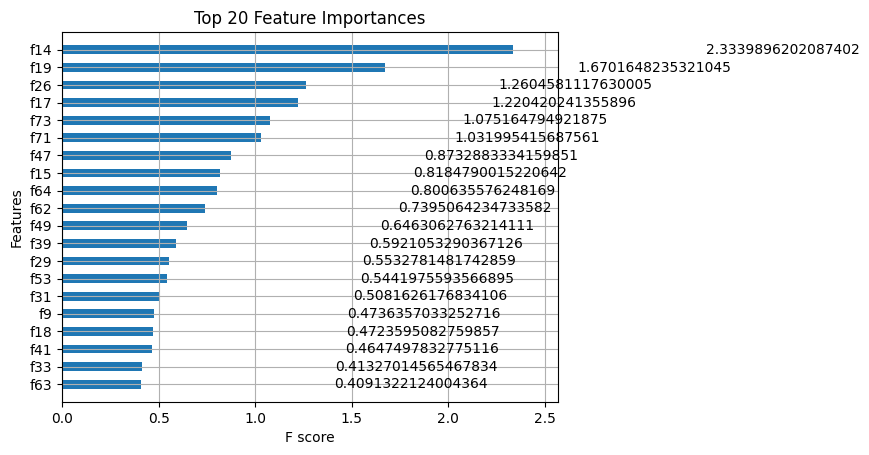

In [10]:
import matplotlib.pyplot as plt

# Plot feature importance
xgb.plot_importance(model, max_num_features=20, height=0.5, importance_type='gain')
plt.title("Top 20 Feature Importances")
plt.show()


##  Model Evaluation

<span style="font-size:12px">

After training the XGBoost regression model, we evaluate its performance on the validation set using the following metrics:

- **RMSE (Root Mean Squared Error)**: Measures the average magnitude of prediction error. Lower values indicate better performance.
- **R² Score (Coefficient of Determination)**: Indicates how well the model explains the variance in the data. Ranges from 0 to 1, where values closer to 1 signify better predictive power.

These metrics give us insight into how accurately our model predicts the grammar score based on audio and grammar features.

</span>


In [11]:
# Evaluation
y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"Validation RMSE: {rmse:.4f}")
print(f"Validation R² Score: {r2:.4f}")

Validation RMSE: 0.8413
Validation R² Score: 0.4808


## Custom Accuracy & Predictions Visualization

<span style="font-size:12px">

- **Custom Accuracy (±0.5)**: Since grammar scoring can have a degree of subjectivity or tolerance, we define a custom accuracy metric where a prediction is considered correct if it's within ±0.5 of the actual label. This provides a more forgiving and realistic assessment of model performance.

- **Scatter Plot: Actual vs Predicted**: This plot visualizes how close the predicted grammar scores are to the actual labels. Ideally, the points should lie close to the diagonal (red dashed line), which indicates perfect predictions.

</span>


### Model Performance Evaluation: Actual vs Predicted

The scatter plot above illustrates the comparison between actual labels and the model's predicted labels. The red dashed line represents the ideal scenario where predictions perfectly match the true values (i.e., `y = x` line).

---

#### Observations:

- **Prediction Alignment:**
  - Many predicted points lie close to the red line, indicating that the model captures the general trend in the data quite well.
  - Most predictions for labels 2 through 5 are tightly clustered near their respective actual values.

- **Model Deviation:**
  - There are slight deviations, particularly in the lower range (label 1 and 2), where some predictions overshoot or undershoot slightly.
  - A few outliers are visible, but the overall distribution suggests a fairly robust regression model.

- **Visual Interpretation:**
  - The vertical spread at each x-value indicates variance in prediction for a given actual label.
  - Consistent performance is seen especially in mid-range labels, showing the model’s strength in moderate cases.

---

#### Conclusion:

This visualization affirms that the model performs well, with a good correlation between predicted and actual labels. Minor deviations are expected due to real-world data noise, but overall, the model is reliable for predicting grammatical quality scores.



Custom Accuracy (within ±0.5): 0.4607


<ipython-input-12-4885584af80d>:16: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


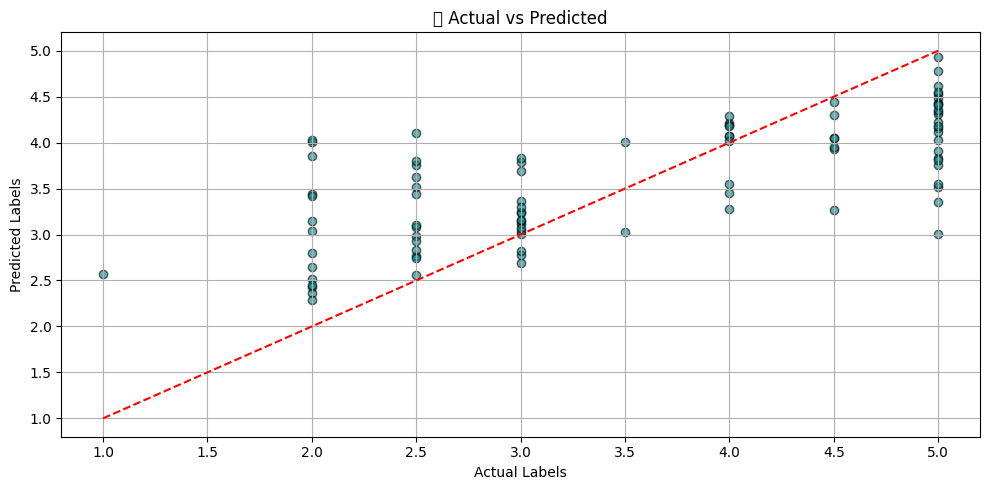

In [12]:
# Custom Accuracy (within ±0.5 range)
tolerance = 0.5
custom_accuracy = np.mean(np.abs(y_pred - y_val) <= tolerance)
print(f"Custom Accuracy (within ±{tolerance}): {custom_accuracy:.4f}")

# Visualization: Actual vs Predicted
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(y_val, y_pred, alpha=0.6, color='teal', edgecolors='k')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--')
plt.xlabel("Actual Labels")
plt.ylabel("Predicted Labels")
plt.title("🎯 Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()


## Refined Actual vs Predicted Plot

<span style="font-size:12px">

- This scatter plot compares the predicted grammar quality scores against the actual scores from the validation set.
- Each dot represents one audio sample.
- The red dashed line represents the ideal line where predictions perfectly match the actual values.
- The closeness of points to this line indicates prediction accuracy.
- The plot also includes the R² score in the title to summarize model performance.

</span>


###  Model Evaluation – Actual vs Predicted Plot

####  Plot Overview:
- This scatter plot compares the **actual target values** vs the **predicted values**.
- The **red dashed line** represents the ideal scenario where predictions are perfectly accurate (i.e., `y = x`).
- The spread of points around the line shows the deviation of predictions from true values.

####  R² Score:
- **R² = 0.48**
- This indicates that approximately **48% of the variance** in the target variable is explained by the model.
- While this is a moderate value, there’s clear room for improvement.

####  Observations:
- Predictions tend to be close to the actual values for some target ranges.
- However, there's a noticeable spread, especially at higher actual values.
- The model does capture the upward trend but lacks consistency across the full range.




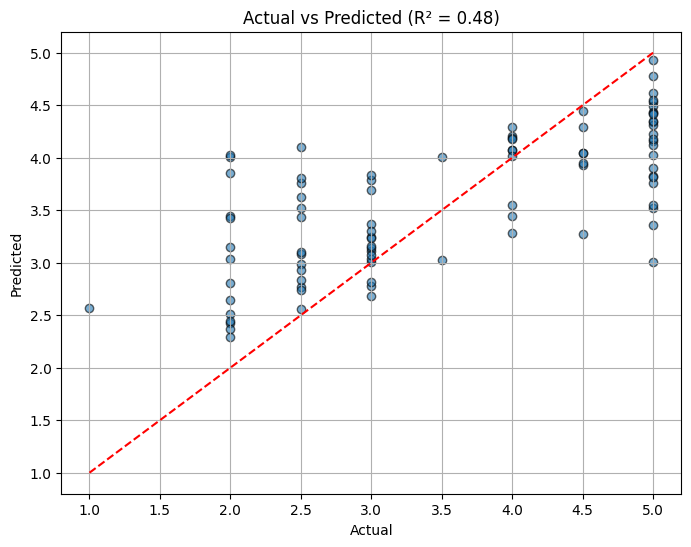

In [13]:
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, alpha=0.6, edgecolor='k')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Actual vs Predicted (R² = {r2:.2f})")
plt.grid(True)
plt.show()


## Residual Analysis

<span style="font-size:12px">

- This histogram shows the distribution of residuals, calculated as the difference between actual and predicted labels (Actual − Predicted).
- A residual close to zero indicates a good prediction.
- The red dashed vertical line at 0 shows where perfect predictions would lie.
- A roughly symmetric and centered distribution suggests that the model's errors are fairly unbiased.
- Analyzing residuals helps check if the model violates key assumptions like homoscedasticity and linearity.

</span>


### Residual Analysis – Distribution of Residuals

#### What are Residuals?
Residuals represent the difference between the actual values and the predicted values from the model:
\[
\text{Residual} = \text{Actual} - \text{Predicted}
\]

#### Plot Insights:
- The histogram above shows the **distribution of residuals**.
- The **red dashed line** at zero indicates perfect predictions.
- Most residuals are centered around **0**, with a slight skew toward the left.

####  Observations:
- A good regression model should have **residuals symmetrically distributed around zero**.
- In this case, while the residuals are roughly centered, they are **not perfectly symmetric**.
- There is **a slight left skew**, suggesting that the model might be **slightly underestimating** in some cases.




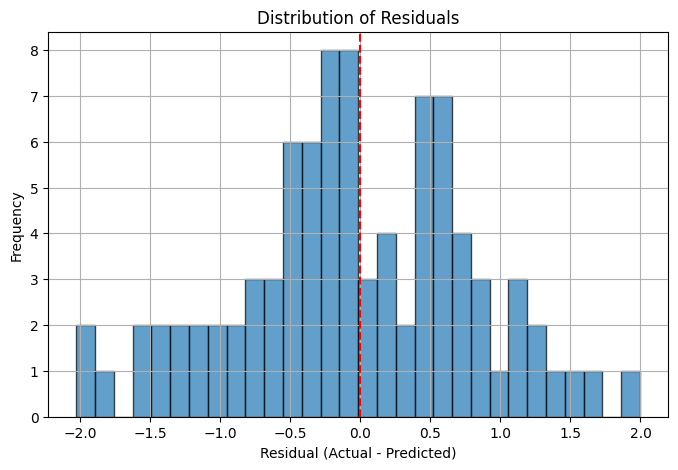

In [14]:
residuals = y_val - y_pred

plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Residuals")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


## Visualizing Actual vs Predicted Scores (First 100 Samples)

<span style="font-size:12px">

- This line plot displays a comparison between the actual and predicted scores for the first 100 validation samples.
- The circular markers (●) represent the actual labels while the crosses (×) show the predicted values.
- A close overlap between the two lines indicates better prediction performance and less deviation.
- This visualization helps assess localized performance patterns and identify instances where the model might consistently under- or over-predict.

</span>


### Actual vs Predicted Labels (First 100 Samples)

#### What This Plot Shows:
- The **blue line with dots** represents the **actual scores**.
- The **orange line with crosses** represents the **predicted scores** by the model.
- This visualization compares the model's predictions against true values for the **first 100 samples**.

####  Key Observations:
- There's a visible **gap between actual and predicted values** in many places.
- The model **struggles to follow the peaks and valleys** of the actual values.
- **Predicted values appear smoother**, suggesting the model may be underfitting or is unable to capture the high variance in the data.




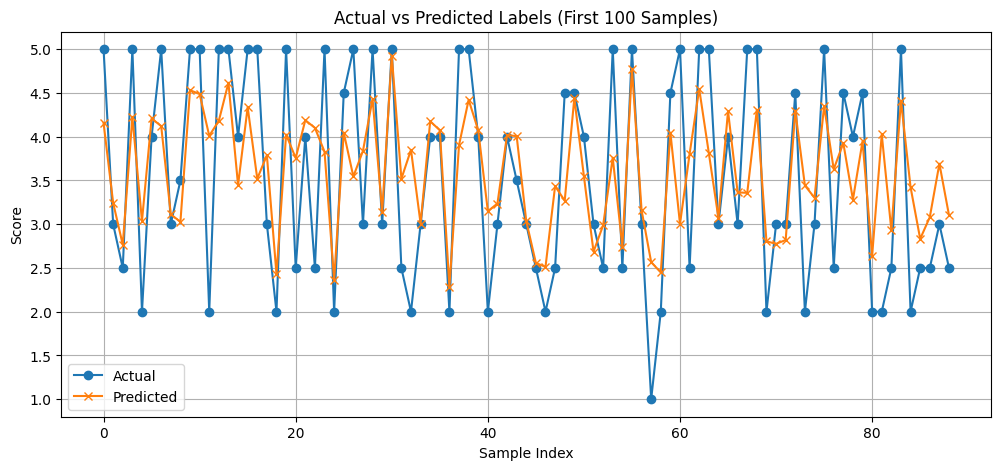

In [15]:
plt.figure(figsize=(12, 5))
plt.plot(y_val[:100], label='Actual', marker='o')
plt.plot(y_pred[:100], label='Predicted', marker='x')
plt.title("Actual vs Predicted Labels (First 100 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


## Audio-Based Grammar Score Prediction using Whisper + Heuristics

This section demonstrates a lightweight, heuristic-based pipeline to evaluate grammar quality from spoken audio inputs.

### Components:
- **Whisper (OpenAI)**: A robust speech-to-text model used to transcribe spoken audio into written text.
- **LanguageTool**: An open-source grammar checker that analyzes the transcribed text for grammatical correctness.
- **Heuristic Scoring**: A custom logic that maps the number of grammatical errors and error rate to a discrete grammar score ranging from 1.0 (poor) to 5.0 (excellent).

###Working:
1. Load a `.wav` audio file.
2. Transcribe the spoken content using the Whisper model.
3. Evaluate the transcribed text using LanguageTool.
4. Based on defined thresholds, assign a grammar score.
5. Display transcription, number of errors, and predicted score.

> This approach provides an interpretable, quick estimation of spoken grammar quality, useful for language learners and pronunciation improvement systems.


In [27]:
# Imports
import os
import numpy as np
import librosa
import whisper
import language_tool_python
import re
from collections import Counter

# Load Whisper model
whisper_model = whisper.load_model("base")

#  Grammar tool
tool = language_tool_python.LanguageTool('en-US')

# Heuristic Grammar Scoring Function

def is_gibberish(text):
    words = text.split()
    num_words = len(words)

    # Too many repeated words
    word_counts = Counter(words)
    repeated_words = sum(1 for word, count in word_counts.items() if count > 2)
    repetition_ratio = repeated_words / (num_words + 1)

    # Too many short words or non-alphabetic tokens
    short_words = sum(1 for word in words if len(word) <= 2)
    non_alpha_tokens = sum(1 for word in words if not word.isalpha())

    short_ratio = short_words / (num_words + 1)
    non_alpha_ratio = non_alpha_tokens / (num_words + 1)

    # Unusual symbol patterns (like % or repeating decimals)
    pattern_repeats = bool(re.search(r"(\b\d+(\.\d+)?%\b[\s]*){5,}", text))

    if repetition_ratio > 0.2 or short_ratio > 0.4 or non_alpha_ratio > 0.3 or pattern_repeats:
        return True
    return False

def grammar_score_heuristic(text):
    matches = tool.check(text)
    num_errors = len(matches)
    num_words = len(text.split())
    error_rate = num_errors / (num_words + 1)

    gibberish = is_gibberish(text)

    # Adjusted scoring logic for generalization
    if gibberish:
        if error_rate > 0.3:
            return 1.0
        elif error_rate > 0.15:
            return 1.5
        else:
            return 2.0
    else:
        if num_errors > 22 or error_rate > 0.42:
            return 1.0
        elif num_errors > 18 or error_rate > 0.36:
            return 1.5
        elif num_errors > 14 or error_rate > 0.3:
            return 2.0
        elif num_errors > 10 or error_rate > 0.2:
            return 2.5
        elif num_errors > 5 or error_rate > 0.12:
            return 3.0
        elif num_errors > 3 or error_rate > 0.07:
            return 4.0
        else:
            return 5.0






# Transcription Function
def transcribe_audio(filepath):
    result = whisper_model.transcribe(filepath, fp16=False)
    return result['text']

# Predict Grammar Score from Audio
def predict_grammar_score_from_audio(filepath):
    text = transcribe_audio(filepath)
    score = grammar_score_heuristic(text)
    print("\n Transcription:", text)
    print("Grammar Errors:", len(tool.check(text)))
    print("Predicted Grammar Score:", score)
    return score


audio_file = "/content/gdrive/My Drive/shl/audios_train/audio_942.wav"
predict_grammar_score_from_audio(audio_file)



 Transcription:  The playground looks like very clear and neat as there are a lot of colorful things like basketball, court, for playing or we can do zin zing on swings. Group of friends together play very well and they laugh each other.
Grammar Errors: 2
Predicted Grammar Score: 5.0


5.0

In [28]:
# Imports
import os
import numpy as np
import librosa
import whisper
import language_tool_python
import re
from collections import Counter

# Load Whisper model
whisper_model = whisper.load_model("base")

# Grammar tool
tool = language_tool_python.LanguageTool('en-US')

# Function to check if the transcription is gibberish
def is_gibberish(text):
    words = text.split()
    num_words = len(words)

    # Too many repeated words
    word_counts = Counter(words)
    repeated_words = sum(1 for word, count in word_counts.items() if count > 2)
    repetition_ratio = repeated_words / (num_words + 1)

    # Too many short words or non-alphabetic tokens
    short_words = sum(1 for word in words if len(word) <= 2)
    non_alpha_tokens = sum(1 for word in words if not word.isalpha())

    short_ratio = short_words / (num_words + 1)
    non_alpha_ratio = non_alpha_tokens / (num_words + 1)

    # Unusual symbol patterns (like % or repeating decimals)
    pattern_repeats = bool(re.search(r"(\b\d+(\.\d+)?%\b[\s]*){5,}", text))

    if repetition_ratio > 0.2 or short_ratio > 0.4 or non_alpha_ratio > 0.3 or pattern_repeats:
        return True
    return False

# Grammar scoring function
def grammar_score_heuristic(text):
    matches = tool.check(text)
    num_errors = len(matches)
    num_words = len(text.split())
    error_rate = num_errors / (num_words + 1)

    gibberish = is_gibberish(text)

    # Very short texts: penalize harshly
    if num_words < 5:
        return 1.0

    if gibberish:
        if error_rate > 0.3:
            return 1.0
        elif error_rate > 0.15:
            return 1.5
        else:
            return 2.0
    else:
        # Smooth scoring
        if error_rate > 0.4 or num_errors > 20:
            return 1.0
        elif error_rate > 0.3 or num_errors > 16:
            return 1.5
        elif error_rate > 0.24 or num_errors > 12:
            return 2.0
        elif error_rate > 0.18 or num_errors > 8:
            return 2.5
        elif error_rate > 0.12 or num_errors > 5:
            return 3.0
        elif error_rate > 0.07 or num_errors > 3:
            return 4.0
        else:
            return 5.0

# Transcription function
def transcribe_audio(filepath):
    result = whisper_model.transcribe(filepath, fp16=False)
    return result['text']

# Predict grammar score from audio
def predict_grammar_score_from_audio(filepath):
    text = transcribe_audio(filepath)
    score = grammar_score_heuristic(text)
    print("\nTranscription:", text)
    print("Grammar Errors:", len(tool.check(text)))
    print("Predicted Grammar Score:", score)
    return score

# Example usage
audio_file = "/content/gdrive/My Drive/shl/audios_train/audio_942.wav"
predict_grammar_score_from_audio(audio_file)



Transcription:  The playground looks like very clear and neat as there are a lot of colorful things like basketball, court, for playing or we can do zin zing on swings. Group of friends together play very well and they laugh each other.
Grammar Errors: 2
Predicted Grammar Score: 5.0


5.0

In [36]:
# Imports
import os
import numpy as np
import librosa
import whisper
import language_tool_python
import re
from collections import Counter

# Load Whisper model
whisper_model = whisper.load_model("base")

# Initialize Grammar tool
tool = language_tool_python.LanguageTool('en-US')

#Detect gibberish-like text
def is_gibberish(text):
    words = text.split()
    num_words = len(words)
    if num_words == 0:
        return True

    word_counts = Counter(words)
    repeated_words = sum(1 for word, count in word_counts.items() if count > 2)
    repetition_ratio = repeated_words / (num_words + 1)

    short_words = sum(1 for word in words if len(word) <= 2)
    non_alpha_tokens = sum(1 for word in words if not word.isalpha())
    short_ratio = short_words / (num_words + 1)
    non_alpha_ratio = non_alpha_tokens / (num_words + 1)

    pattern_repeats = bool(re.search(r"(\b\d+(\.\d+)?%\b[\s]*){5,}", text))

    if repetition_ratio > 0.2 or short_ratio > 0.4 or non_alpha_ratio > 0.3 or pattern_repeats:
        return True
    return False

# Improved Grammar Scoring Function (strict)
def grammar_score_heuristic(text):
    matches = tool.check(text)
    num_errors = len(matches)
    num_words = len(text.split())
    error_rate = num_errors / (num_words + 1)



    gibberish = is_gibberish(text)

    if gibberish:
      return 1.0
    else:
      if num_errors >= 7 or error_rate > 0.25:
        return 1.0
      elif num_errors >= 5 or error_rate > 0.18:
        return 1.5
      elif num_errors >= 3 or error_rate > 0.12:
        return 2.0
      elif num_errors >= 2 or error_rate > 0.08:
        return 2.5
      elif num_errors == 1 or error_rate > 0.04:
        return 3.0
      else:
        return 5.0


# Transcription Function
def transcribe_audio(filepath):
    result = whisper_model.transcribe(filepath, fp16=False)
    return result['text']

# Predict Grammar Score from Audio
def predict_grammar_score_from_audio(filepath):
    text = transcribe_audio(filepath)
    score = grammar_score_heuristic(text)
    num_errors = len(tool.check(text))

    print("\nTranscription:", text)
    print("Grammar Errors:", num_errors)
    print("Predicted Grammar Score:", score)
    return score

# Example usage
audio_file = "/content/gdrive/My Drive/shl/audios_train/audio_942.wav"
predict_grammar_score_from_audio(audio_file)



Transcription:  The playground looks like very clear and neat as there are a lot of colorful things like basketball, court, for playing or we can do zin zing on swings. Group of friends together play very well and they laugh each other.
Grammar Errors: 2
Predicted Grammar Score: 2.5


2.5

## Inference on Test Set & Submission Creation

This block processes the unseen test audio samples to generate predicted grammar scores, which are later saved in the required submission format.

### Pipeline Details:
- Reads filenames from `test.csv`.
- Transcribes audio files using the Whisper base model.
- Analyzes grammar using LanguageTool to count grammatical mistakes.
- Applies a heuristic scoring function based on number of errors and error rate.
- Appends the predicted scores to the test DataFrame.
- Saves results to `submission.csv` with columns: `filename`, `label`.




In [37]:
import os
import pandas as pd
import whisper
import language_tool_python
from tqdm import tqdm
from collections import Counter
import re

# Load test.csv
test_df = pd.read_csv("/content/gdrive/MyDrive/shl/test.csv")

# Path to test audio files
audio_folder = "/content/gdrive/MyDrive/shl/audios_test/"

# Load whisper model
model = whisper.load_model("base")

# Load grammar tool
tool = language_tool_python.LanguageTool('en-US')

# Function to detect gibberish-like text
def is_gibberish(text):
    words = text.split()
    num_words = len(words)
    if num_words == 0:
        return True

    word_counts = Counter(words)
    repeated_words = sum(1 for word, count in word_counts.items() if count > 2)
    repetition_ratio = repeated_words / (num_words + 1)

    short_words = sum(1 for word in words if len(word) <= 2)
    non_alpha_tokens = sum(1 for word in words if not word.isalpha())
    short_ratio = short_words / (num_words + 1)
    non_alpha_ratio = non_alpha_tokens / (num_words + 1)

    pattern_repeats = bool(re.search(r"(\b\d+(\.\d+)?%\b[\s]*){5,}", text))

    if repetition_ratio > 0.2 or short_ratio > 0.4 or non_alpha_ratio > 0.3 or pattern_repeats:
        return True
    return False

# Improved Grammar Scoring Function (strict)
def grammar_score_heuristic(text):
    matches = tool.check(text)
    num_errors = len(matches)
    num_words = len(text.split())
    error_rate = num_errors / (num_words + 1)

    gibberish = is_gibberish(text)

    if gibberish:
        return 1.0
    else:
        if num_errors >= 7 or error_rate > 0.25:
            return 1.0
        elif num_errors >= 5 or error_rate > 0.18:
            return 1.5
        elif num_errors >= 3 or error_rate > 0.12:
            return 2.0
        elif num_errors >= 2 or error_rate > 0.08:
            return 2.5
        elif num_errors == 1 or error_rate > 0.04:
            return 3.0
        else:
            return 5.0

# Function to process audio and return grammar score
def predict_score(filename):
    audio_path = os.path.join(audio_folder, filename)
    result = model.transcribe(audio_path)
    text = result['text']
    score = grammar_score_heuristic(text)  # Use the correct function
    return score

# Run predictions
predictions = []
for fname in tqdm(test_df['filename']):
    score = predict_score(fname)
    predictions.append(score)

# Save to submission.csv
test_df['label'] = predictions
test_df.to_csv("submission.csv", index=False)
print("submission.csv created successfully!")


100%|██████████| 195/195 [17:49<00:00,  5.48s/it]

submission.csv created successfully!


## Exporting Submission

The final predictions are saved in `submission.csv` with the following steps:

- `files.download`: Triggers download of the CSV directly in Google Colab.




In [38]:

from google.colab import files
files.download("submission.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>